#**TASK 1**

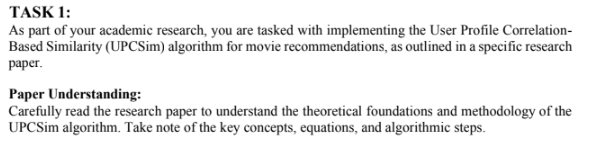

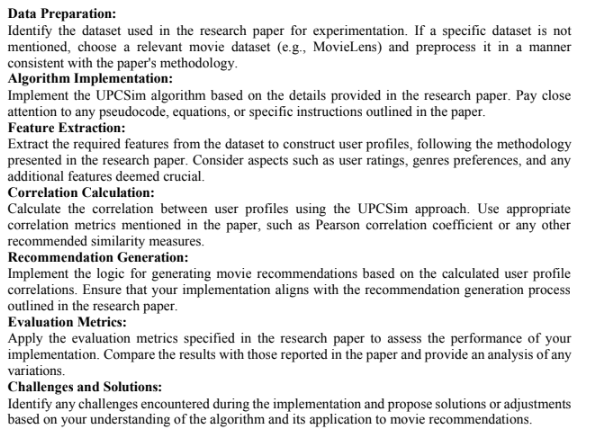

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
movies = pd.read_csv('movie.csv')
ratings = pd.read_csv('ratings.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,7273526,50196,858,5.0,2007-06-05 15:27:45
1,9776512,67571,14,2.0,1997-03-31 20:26:34
2,14426482,99674,8014,2.0,2007-02-21 19:34:12
3,3557525,24238,424,4.0,2005-11-20 21:05:01
4,3572307,24372,45950,5.0,2007-02-06 22:14:53


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000013 entries, 0 to 1000012
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1000013 non-null  int64  
 1   userId      1000013 non-null  int64  
 2   movieId     1000013 non-null  int64  
 3   rating      1000013 non-null  float64
 4   timestamp   1000013 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 38.1+ MB


In [ ]:
mostrated = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)
mostrated_movies = movies[movies['movieId'].isin(mostrated.index)]

In [ ]:
mr=mostrated_movies.merge(mostrated, on='movieId', how='inner').rename(columns={'rating': 'num_ratings'})
print(mr)

   movieId                                      title  \
0        1                           Toy Story (1995)   
1      110                          Braveheart (1995)   
2      260  Star Wars: Episode IV - A New Hope (1977)   
3      296                        Pulp Fiction (1994)   
4      318           Shawshank Redemption, The (1994)   
5      356                        Forrest Gump (1994)   
6      480                       Jurassic Park (1993)   
7      589          Terminator 2: Judgment Day (1991)   
8      593           Silence of the Lambs, The (1991)   
9     2571                         Matrix, The (1999)   

                                        genres  num_ratings  
0  Adventure|Animation|Children|Comedy|Fantasy         2510  
1                             Action|Drama|War         2546  
2                      Action|Adventure|Sci-Fi         2667  
3                  Comedy|Crime|Drama|Thriller         3353  
4                                  Crime|Drama         3182  


In [ ]:
ratings_user = ratings.groupby('userId')['rating'].count()

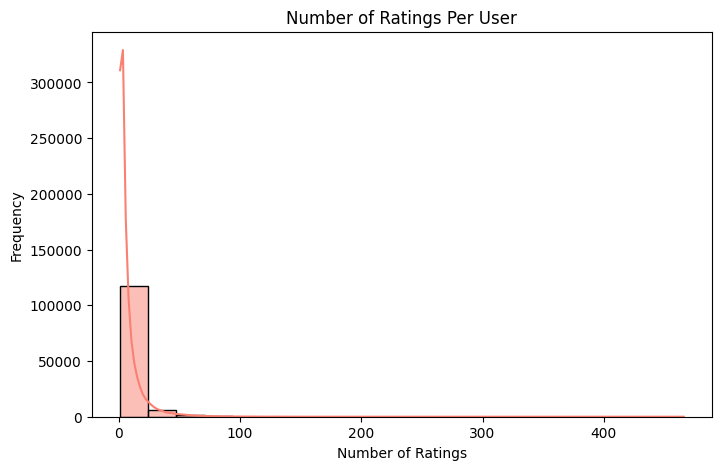

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(ratings_user, bins=20, kde=True, color='salmon')
plt.title("Number of Ratings Per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df = pd.merge(ratings, movies, on='movieId')
df = df.dropna(subset=['userId', 'movieId', 'rating'])

In [ ]:
movies['genres_split'] = movies['genres'].str.split('|')

g = [genre for genres_list in movies['genres_split'].dropna() for genre in genres_list]
genre_counts = pd.Series(g).value_counts()

In [ ]:
genre_counts

,count
Drama,13344
Comedy,8374
Thriller,4178
Romance,4127
Action,3520
Crime,2939
Horror,2611
Documentary,2471
Adventure,2329
Sci-Fi,1743


<ipython-input-24-d40f48adfcd6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='coolwarm',legend=False)


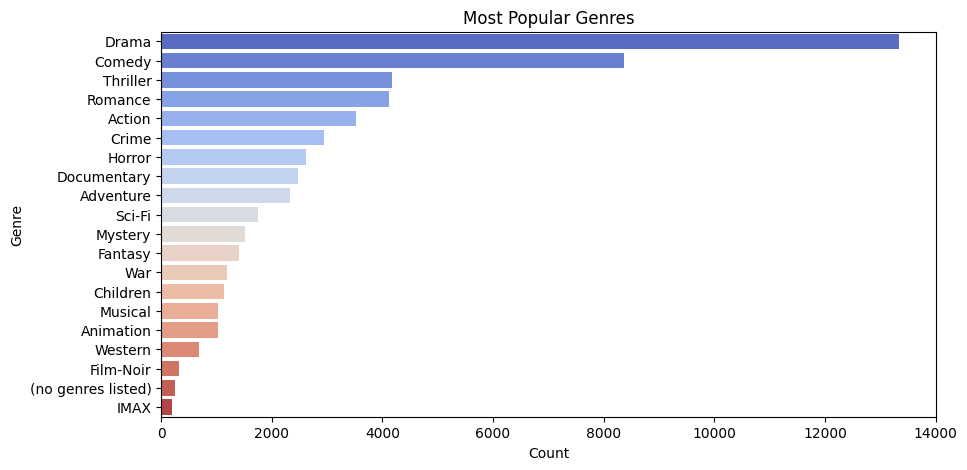

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='coolwarm',legend=False)
plt.title("Most Popular Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

In [ ]:
df = df[df['userId'].isin(df['userId'].sample(1000))]

In [ ]:
df2 = df.pivot_table(index='title', columns='userId', values='rating').fillna(0)

##Similarity Functions

In [ ]:
def dist(pt, movie1, movie2):
    cr = (pt.loc[movie1] != 0) & (pt.loc[movie2] != 0)
    if not cr.any():
        return 0
    distance = np.sqrt(np.sum((pt.loc[movie1][cr] - pt.loc[movie2][cr]) ** 2))
    return 1 / (1 + distance)

In [ ]:
def pearson(pt, movie1, movie2):
    cr = (pt.loc[movie1] != 0) & (pt.loc[movie2] != 0)
    if not cr.any():
        return 0
    ratings1 = pt.loc[movie1][cr]
    ratings2 = pt.loc[movie2][cr]
    return np.corrcoef(ratings1, ratings2)[0, 1]


##Recommendation Function

In [ ]:
def recommend(movie_name, similarity_func=pearson):
    if movie_name not in df2.index:
        print(f"'{movie_name}' not found in the dataset.")
        return

    sim = [(similarity_func(df2, movie_name, other_movie), other_movie)

    for other_movie in df2.index if other_movie != movie_name]
    sim_items = sorted(sim, key=lambda x: x[0], reverse=True)[:5]
    print(f"\nRecommendations for '{movie_name}':")

    for score, movie_title in sim_items:
        print(f"{movie_title} (Similarity: {score:.2f})")


##Testing Recommendations

In [ ]:
recommend('Toy Story (1995)', similarity_func=pearson)



Recommendations for 'Toy Story (1995)':
'71 (2014) (Similarity: nan)
'Round Midnight (1986) (Similarity: nan)
Broken Arrow (1996) (Similarity: 1.00)
Casper (1995) (Similarity: 1.00)
Armageddon (1998) (Similarity: 1.00)


In [ ]:
recommend('Sabrina (1995)', similarity_func=dist)


Recommendations for 'Sabrina (1995)':
Airplane! (1980) (Similarity: 1.00)
Alien: Resurrection (1997) (Similarity: 1.00)
Bamba, La (1987) (Similarity: 1.00)
Barefoot in the Park (1967) (Similarity: 1.00)
Basic Instinct (1992) (Similarity: 1.00)


#**TASK 2**

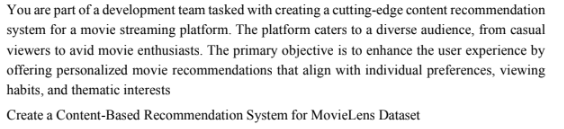

In [ ]:
movies = pd.read_csv('movie.csv')
ratings = pd.read_csv('ratings.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [ ]:
ratings

,Unnamed: 0,userId,movieId,rating,timestamp
0,7273526,50196,858,5.0,2007-06-05 15:27:45
1,9776512,67571,14,2.0,1997-03-31 20:26:34
2,14426482,99674,8014,2.0,2007-02-21 19:34:12
3,3557525,24238,424,4.0,2005-11-20 21:05:01
4,3572307,24372,45950,5.0,2007-02-06 22:14:53
...,...,...,...,...,...
1000008,10285965,71144,3082,5.0,1999-12-11 22:23:19
1000009,8675341,59917,3175,5.0,1999-12-26 17:41:39
1000010,13368985,92398,733,3.0,1997-01-01 22:43:52
1000011,6176568,42493,1544,3.0,2008-08-19 04:51:37


In [ ]:
movies['genres'] = movies['genres'].str.split('|')

In [ ]:
# Combining genres into a single string
movies['genres_str'] = movies['genres'].apply(lambda x: ' '.join(x))
print(movies[['title', 'genres', 'genres_str']].head())


                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                              genres  \
0  [Adventure, Animation, Children, Comedy, Fantasy]   
1                     [Adventure, Children, Fantasy]   
2                                  [Comedy, Romance]   
3                           [Comedy, Drama, Romance]   
4                                           [Comedy]   

                                    genres_str  
0  Adventure Animation Children Comedy Fantasy  
1                   Adventure Children Fantasy  
2                               Comedy Romance  
3                         Comedy Drama Romance  
4                                       Comedy  


##vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres_str'])

print(tfidf_matrix.shape)


(27278, 23)


In [ ]:
from sklearn.metrics.pairwise import linear_kernel

movie_indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def recommend(title, tfidf_matrix=tfidf_matrix):
    id = movie_indices[title]
    sim_score = linear_kernel(tfidf_matrix[id], tfidf_matrix).flatten()

    # Sort the movies
    sim_score = list(enumerate(sim_score))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)

    #top 10 similar movies
    sim_score = sim_score[1:11]
    movie_recom = [i[0] for i in sim_score]
    return movies['title'].iloc[movie_recom]



6                          Sabrina (1995)
38                        Clueless (1995)
63                   Two if by Sea (1996)
67     French Twist (Gazon maudit) (1995)
116                   If Lucy Fell (1996)
120                      Boomerang (1992)
127                 Pie in the Sky (1996)
178                       Mallrats (1995)
184                    Nine Months (1995)
234                   Forget Paris (1995)
Name: title, dtype: object


In [ ]:
print(recommend('Sabrina (1995)'))

6                          Sabrina (1995)
38                        Clueless (1995)
63                   Two if by Sea (1996)
67     French Twist (Gazon maudit) (1995)
116                   If Lucy Fell (1996)
120                      Boomerang (1992)
127                 Pie in the Sky (1996)
178                       Mallrats (1995)
184                    Nine Months (1995)
234                   Forget Paris (1995)
Name: title, dtype: object
